In [1]:
import os
import torch
import open3d 
import open3d.ml.torch as ml3d
from poss_dataset import POSSDataset

device = torch.device('cpu')
print(f"Using device: {device}")
print(f"Open3D version: {open3d.__version__}")

Using device: cpu
Open3D version: 0.18.0


In [2]:
import yaml
import os

poss_config = {
    'learning_map': {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12, 13:13, 14:14, 15:15, 16:16},
    'learning_map_inv': {i: i for i in range(17)},
    'learning_ignore': {0: True, **{i: False for i in range(1, 17)}}
}
with open('poss.yaml', 'w') as f:
    yaml.dump(poss_config, f)

randla_config = {
    'dataset': {
        'name': 'POSS',
        'dataset_path': os.path.abspath('./'),
        'cache_dir': './logs/cache_poss',
        'use_cache': True,
        'sampler': {'name': 'SemSegRandomSampler'},
        'class_weights': [1.0] * 17
    },
    'model': {
        'name': 'RandLANet',
        'batcher': 'DefaultBatcher',
        'num_neighbors': 16,
        'num_layers': 4,
        'num_points': 45056, 
        'num_classes': 17,
        'ignored_label_inds': [0],
        'sub_sampling_ratio': [4, 4, 4, 4],
        'in_channels': 3,
        'dim_features': 8,
        'dim_output': [16, 64, 128, 256],
        'grid_size': 0.06
    },
    'pipeline': {
        'name': 'SemanticSegmentation',
        'optimizer': {'lr': 0.01},
        'batch_size': 2, # CPU только такой потянет
        'main_log_dir': './logs',
        'max_epoch': 10, 
        'save_ckpt_freq': 1,
        'scheduler_gamma': 0.9886,
        'test_batch_size': 1,
        'val_batch_size': 1,
        'num_workers': 0 
    }
}

with open('randlanet_poss.yml', 'w') as f:
    yaml.dump(randla_config, f, default_flow_style=False)

print("Strict configuration created.")

Strict configuration created.


In [4]:
import yaml
import torch
import open3d.ml.torch as ml3d
from poss_dataset import POSSDataset

class AttrDict(dict):
    def __init__(self, d):
        super().__init__(d)
        for k, v in d.items():
            if isinstance(v, dict):
                self[k] = AttrDict(v)
            else:
                self[k] = v
    def __getattr__(self, key):
        return self[key]

with open("randlanet_poss.yml", 'r') as f:
    cfg = AttrDict(yaml.safe_load(f))

dataset = POSSDataset(
    dataset_path=cfg.dataset.dataset_path, 
    poss_yaml_path="poss.yaml",
    cache_dir=cfg.dataset.cache_dir,
    use_cache=cfg.dataset.use_cache,
    class_weights=cfg.dataset.class_weights,
    training_split=["00", "01", "02", "03"], 
    validation_split=["04"],
    test_split=["05"]
)

model = ml3d.models.RandLANet(**cfg.model)

pipeline = ml3d.pipelines.SemanticSegmentation(
    model=model,
    dataset=dataset,
    device='cpu',
    **cfg.pipeline
)

print(f"Dataset initialized. Training on sequences: {dataset.cfg.training_split}")

Dataset initialized. Training on sequences: ['00', '01', '02', '03']


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

print("Training...")

class RandLADatasetWrapper(Dataset):
    def __init__(self, split_obj, model):
        self.split = split_obj
        self.model = model
        self.attr = {'split': 'train'}
        
    def __len__(self):
        return len(self.split)
    
    def __getitem__(self, idx):
        # Читаем данные и сразу прогоняем через препроцессинг модели
        data = self.split.get_data(idx)
        data['label'] = data['label'].reshape([-1])
        data = self.model.preprocess(data, self.attr)
        data = self.model.transform(data, self.attr)
        return data

# Инициализация 
train_split_obj = dataset.get_split('train')
train_dataset = RandLADatasetWrapper(train_split_obj, model)

batcher = pipeline.get_batcher(device)

loader = DataLoader(
    train_dataset,
    batch_size=2, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=batcher.collate_fn
)

# Лосс и Оптимизатор
class SimpleLoss:
    def __init__(self, dataset, device):
        w = torch.tensor(dataset.class_weights, dtype=torch.float32).to(device)
        self.ce = nn.CrossEntropyLoss(weight=w)
    
    def weighted_CrossEntropyLoss(self, scores, labels):
        return self.ce(scores, labels.long())

Loss = SimpleLoss(dataset, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучение
print(f"Starting training on {len(train_dataset)} frames from sequences 00-03.")
print("Calculating Accuracy")

model.device = device 
model.to(device)
model.train()

for epoch in range(5): 
    print(f"\n=== Epoch {epoch+1}/5 started ===")
    
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}")
    
    epoch_loss = []
    epoch_acc = []
    
    for i, batch in enumerate(pbar):
        # Распаковка и перенос на Device
        if isinstance(batch, dict) and 'data' in batch:
            inputs = batch['data']
        else:
            inputs = batch
            batch = {'data': inputs}
            
        if isinstance(inputs, dict):
            for k, v in inputs.items():
                if isinstance(v, torch.Tensor):
                    inputs[k] = v.to(device)
                elif isinstance(v, list):
                    inputs[k] = [x.to(device) if isinstance(x, torch.Tensor) else x for x in v]
        
        optimizer.zero_grad()
        
        # Forward pass
        results = model(inputs) # [Batch, Points, Classes]
        
        # Loss
        loss, _, _ = model.get_loss(Loss, results, batch, device)
        
        # Accuracy
        preds = torch.argmax(results, dim=-1) 
        targets = inputs['labels']            
        
        correct = (preds == targets).sum().item()
        total = targets.numel()
        accuracy = correct / total
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Логирование
        epoch_loss.append(loss.item())
        epoch_acc.append(accuracy)
        
        # Текущий Loss и Accuracy
        pbar.set_postfix({
            'loss': f"{loss.item():.3f}", 
            'acc': f"{accuracy:.2%}"
        })

    # Итоги эпохи
    avg_loss = sum(epoch_loss) / len(epoch_loss)
    avg_acc = sum(epoch_acc) / len(epoch_acc)
    print(f"Epoch {epoch+1} Done. Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_acc:.2%}")

print("Training finished successfully")

Training...
Starting training on 1988 frames from sequences 00-03.
Calculating Accuracy

=== Epoch 1/5 started ===


Epoch 1: 100%|█████████| 994/994 [42:05<00:00,  2.54s/it, loss=0.744, acc=0.40%]


Epoch 1 Done. Avg Loss: 0.9765, Avg Accuracy: 1.44%

=== Epoch 2/5 started ===


Epoch 2: 100%|███████| 994/994 [1:23:51<00:00,  5.06s/it, loss=0.249, acc=0.02%]


Epoch 2 Done. Avg Loss: 0.5770, Avg Accuracy: 1.16%

=== Epoch 3/5 started ===


Epoch 3: 100%|█████████| 994/994 [59:41<00:00,  3.60s/it, loss=0.451, acc=0.58%]


Epoch 3 Done. Avg Loss: 0.4093, Avg Accuracy: 1.10%

=== Epoch 4/5 started ===


Epoch 4: 100%|█████████| 994/994 [43:41<00:00,  2.64s/it, loss=0.372, acc=2.19%]


Epoch 4 Done. Avg Loss: 0.3358, Avg Accuracy: 0.99%

=== Epoch 5/5 started ===


Epoch 5: 100%|█████████| 994/994 [58:48<00:00,  3.55s/it, loss=0.134, acc=0.61%]

Epoch 5 Done. Avg Loss: 0.2891, Avg Accuracy: 0.89%
Training finished successfully


🎲 Random Selection: Sequence 01 | Frame 000459


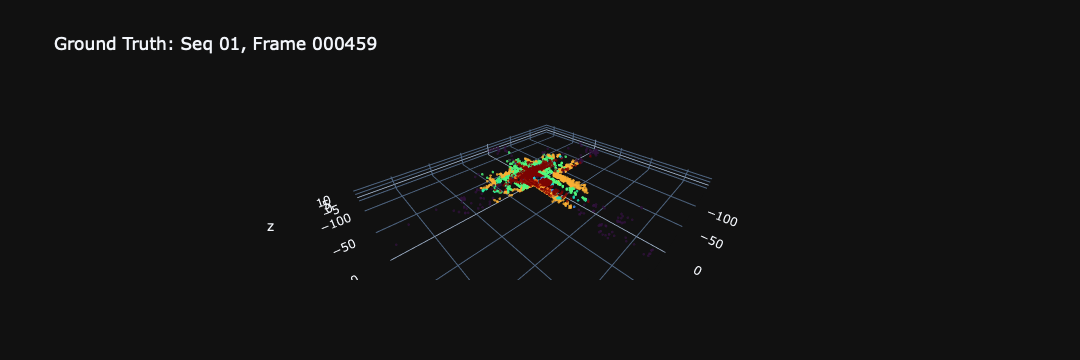

In [15]:
import numpy as np
import plotly.graph_objects as go
import os
import random

def visualize_random_poss(root_dir='./'):
    seq_root = os.path.join(root_dir, 'dataset', 'sequences')
    
    if not os.path.exists(seq_root):
        print(f"Error: Path {seq_root} does not exist.")
        return

    # Выбираем случайную папку
    sequences = [d for d in os.listdir(seq_root) if os.path.isdir(os.path.join(seq_root, d))]
    if not sequences:
        print("No sequences found.")
        return
    
    chosen_seq = random.choice(sequences)
    
    velo_path = os.path.join(seq_root, chosen_seq, 'velodyne')
    files = [f for f in os.listdir(velo_path) if f.endswith('.bin')]
    
    if not files:
        print(f"No bin files in sequence {chosen_seq}")
        return
        
    chosen_file = random.choice(files)
    file_id = chosen_file.replace('.bin', '') 
    
    bin_path = os.path.join(velo_path, chosen_file)
    label_path = os.path.join(seq_root, chosen_seq, 'labels', file_id + '.label')
    
    print(f"🎲 Random Selection: Sequence {chosen_seq} | Frame {file_id}")

    # Загружаем и рисуем каждую 15-ю точку, чтобы не тормозило (cpu подводит)
    pts = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[::15]
    
    if os.path.exists(label_path):
        lbs = np.fromfile(label_path, dtype=np.uint32)[::15] & 0xFFFF
        color_val = lbs
        colorscale = 'Turbo' # Для классов (разноцветный)
        title = f"Ground Truth: Seq {chosen_seq}, Frame {file_id}"
    else:
        color_val = pts[:, 3]
        colorscale = 'Viridis'
        title = f"Raw Point Cloud: Seq {chosen_seq}, Frame {file_id}"

    fig = go.Figure(data=[go.Scatter3d(
        x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
        mode='markers',
        marker=dict(size=1.5, color=color_val, colorscale=colorscale, opacity=0.8)
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(aspectmode='data'),
        template='plotly_dark'
    )
    fig.show()

# Запуск
visualize_random_poss()